# 4X User Study Analysis
This notebook is used to analyze data from the 4X study conducted in March 2018.

# Imports and Global Setup

In [1]:
import json
from functools import reduce
from collections import Counter

import requests
import pandas as pd
import numpy as np

from datetime import datetime, timezone
from copy import deepcopy
from tqdm import *

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

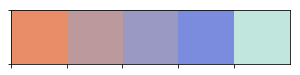

In [3]:
# defining colors
COLORS = {
    'ORANGE': '#E88D67',
    'PINK': '#BB999C',
    'VIOLET': '#9999C3',
    'BLUE': '#7B8CDE',
    'GREEN': '#C0E6DE'
}

# palette
sns.set_palette(COLORS.values())
sns.palplot(sns.color_palette())
sns.set(font_scale=1.5, style='whitegrid')

# Load in data

In [4]:
# URLs for different conditions
url_4x = 'https://les-4x.herokuapp.com/parse/classes/'
url_opp_location = 'https://les-opplocation.herokuapp.com/parse/classes/'
url_opp_distance = 'https://les-oppdistance.herokuapp.com/parse/classes/'

# shared header and data
header = {'X-Parse-Application-Id': 'PkngqKtJygU9WiQ1GXM9eC0a17tKmioKKmpWftYr'}
data = {'limit': '10000'}

# study start and end
start_time = '2018-03-05 06:00:00'
end_time = '2018-03-19 05:00:00'
print('Study Length: {}'.format(datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S') - datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')))

Study Length: 13 days, 23:00:00


In [5]:
def load_data(base_url, header, data, start_time, end_time):
    """
    Loads in all needed tables from database, given url.
    
    Input: 
        base_url (string): url to pull data from
        header (dict): application id and other auth
        data (dict): data to pass into query
        start_time (datetime): start time for data
        end_time (datetime): end time for data 
    
    Return:
        (dict): dict where keys are collection names and values are Pandas objects containing data
    """
    # declare collection list
    collection_list = ['_User', 'ServerLog', 'DebugLog', 'ForYouViewLog', 'ApplicationHeartbeat',
                       'TaskLocations', 'LocationTypeMetadata', 'beacons', 'EnRouteLocations',
                       'AtLocationNotificationsSent', 'AtLocationNotificationResponses',
                       'EnRouteNotificationsSent', 'EnRouteNotificationResponses',
                       'AtDistanceNotificationsSent', 'AtDistanceNotificationResponses']
    
    # loop through and load data for each collection
    output = {}
    for collection in tqdm(collection_list):
        current_response = requests.get(base_url + collection, headers=header, data=data)

        current_data = pd.DataFrame(current_response.json()['results'])
        if len(current_data) != 0:
            current_data['createdAt'] = pd.to_datetime(current_data['createdAt'])
            current_data['updatedAt'] = pd.to_datetime(current_data['updatedAt'])
            
            if collection != '_User':
                current_data = current_data[(current_data['createdAt'] >= start_time) & (current_data['createdAt'] < end_time)]

        output[collection] = current_data
    
    return output

In [6]:
data_4x = load_data(url_4x, header, data, start_time, end_time)

100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


In [7]:
data_opp_loc = load_data(url_opp_location, header, data, start_time, end_time)

100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


In [8]:
data_opp_dist = load_data(url_opp_distance, header, data, start_time, end_time)

100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


# Data Dashboard
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper

## Common Functions

In [9]:
def get_merged_at_location(tasklocations, atlocnotif, atlocresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtLocation case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atlocnotif (DataFrame): DataFrame of AtLocationNotificationsSent
        atlocresp (DataFrame): DataFrame of AtLocationNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtLocationNotifications
    atlocnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], inplace=True)
    atlocnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtLocationNotificationResponses
    atlocresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], inplace=True)
    atlocresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtLocation notifications and responses, with some data from TaskLocations
    atloc = atlocnotif.merge(tasklocations[['objectId', 'locationType', 'locationName', 'beaconId']],
                             how='inner', left_on='taskLocationId', right_on='objectId')
    atloc = atloc.merge(atlocresp[['question', 'response', 'timestamp', 'taskLocationId', 'vendorId']],
                        how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atloc['objectId']
    atloc.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'},
                 inplace=True)
    
    # fill blank columns
    atloc[['question', 'response']] = atloc[['question', 'response']].fillna(value='missed notification')
    atloc[['distanceToLocation', 'responseTimestamp']] = atloc[['distanceToLocation', 'responseTimestamp']].fillna(value=-1)

    # type columns
    atloc_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atloc[atloc_int_cols] = atloc[atloc_int_cols].apply(lambda x: x.astype(np.int64))
    
    # add validResponse column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'missed notification']
    atloc['remappedResponses'] = atloc['response']
    atloc.loc[~atloc['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'valid response'
    atloc.loc[atloc['remappedResponses'] == 'com.apple.UNNotificationDismissActionIdentifier', 'remappedResponses'] = 'dismissed notification'
    
    # reorder columns
    atloc_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation',
                          'locationType', 'locationName','gmtOffset', 'notificationTimestamp', 'notificationString',
                          'question', 'response', 'remappedResponses', 'responseTimestamp']
    atloc = atloc[atloc_col_ordering]
    
    return atloc

In [10]:
def get_merged_at_distance(tasklocations, atdistnotif, atdistresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtDistance case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atdistnotif (DataFrame): DataFrame of AtDistanceNotificationsSent
        atdistresp (DataFrame): DataFrame of AtDistanceNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtDistanceNotifications
    atdistnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], inplace=True)
    atdistnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses
    atdistresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], inplace=True)
    atdistresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtDistance notifications and responses, with some data from TaskLocations
    atdist = atdistnotif.merge(tasklocations[['objectId', 'beaconId', 'locationName']],
                               how='inner', left_on='taskLocationId', right_on='objectId')
    atdist = atdist.merge(atdistresp[['emaResponse', 'timestamp', 'taskLocationId', 'vendorId']],
                          how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atdist['objectId']
    atdist.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    atdist_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation', 'bearingToLocation',
                           'locationType', 'locationName', 'notificationDistance', 'sentBy', 'infoIncluded',
                           'gmtOffset', 'notificationTimestamp', 'emaResponse', 'responseTimestamp']
    atdist = atdist[atdist_col_ordering]
    
    # fill blank columns
    atdist['emaResponse'] = atdist['emaResponse'].fillna(value='missed notification')
    atdist.loc[atdist['emaResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'emaResponse'] = 'dismissed notification'
    
    atdist['responseTimestamp'] = atdist['responseTimestamp'].fillna(value=-1)

    # type columns
    atdist_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atdist[atdist_int_cols] = atdist[atdist_int_cols].apply(lambda x: x.astype(np.int64))
    
    return atdist

In [11]:
def get_merged_en_route(tasklocations, enroutenotif, enrouteresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for EnRoute case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        enroutenotif (DataFrame): DataFrame of EnRouteNotificationsSent
        enrouteresp (DataFrame): DataFrame of EnRouteNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    pass

In [12]:
def get_dead_apps(serverlog):
    """
    Returns a list of lists for dead apps that server has notified.
    
    Input: 
        server (DataFrame): DataFrame of ServerLog
    
    Return:
        (list of lists of strings): all dead applications notified via push
    """
    notify_log_strings = serverlog[serverlog['logString'].str.contains('Notified dead')]['logString']
    deadapp_notif_list = list(notify_log_strings.apply(lambda x: x[x.find('[') + 1:-1].split(', ')))
    return deadapp_notif_list

## 4X

### Setup Data

In [13]:
users_4x = deepcopy(data_4x['_User'])
users_4x = users_4x[users_4x['vendorId'] != '']

In [14]:
serverlog_4x = deepcopy(data_4x['ServerLog'])
deadapp_notify_4x = get_dead_apps(serverlog_4x)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_4x[-1]),
                                                          '\n'.join(deadapp_notify_4x[-1])))

flattened_deadapps_4x = reduce(lambda x, y: x + y, deadapp_notify_4x, [])
Counter(flattened_deadapps_4x)

Last dead apps notified (count = 15): 
B58B0DF7-8DA5-4A22-98EF-2AE712D4DB10
4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F
F57CB6D4-09B3-4796-AE91-2F31BADEE832
79CCD350-AAC5-4586-A6FC-1948B49A4B10
95674A2B-6954-49C6-9456-A7F865CE686E
437A2325-CA4D-4426-9F1A-F89E412A00AC
E89FDDC1-0ADA-4249-B9AD-40F24FD9DE30
B0686F52-978C-4925-A466-E7A6A765B258
53F61BDE-FFC0-476A-AF7B-D592F4155AC8
D3D3D1E2-1F39-4AB8-917D-52876AA63830
E78771C1-08B3-4483-99D8-4A081E98DABC
C89DDEDC-F459-40BA-8073-EAFF7FC53C34
FDEFE367-350F-4B8B-898E-710487D51BF4
8617CA10-E2AD-4420-B92B-AF170930FDB1
203FE158-68A6-496F-B72E-274A4417983A


Counter({'0EC5DDE3-5D78-4025-AC41-EF6EEF9612FC': 1,
         '203FE158-68A6-496F-B72E-274A4417983A': 1,
         '437A2325-CA4D-4426-9F1A-F89E412A00AC': 1,
         '4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F': 2,
         '4DFAD945-87C6-4219-B237-7345E7600105': 1,
         '53F61BDE-FFC0-476A-AF7B-D592F4155AC8': 2,
         '79CCD350-AAC5-4586-A6FC-1948B49A4B10': 2,
         '8617CA10-E2AD-4420-B92B-AF170930FDB1': 1,
         '95674A2B-6954-49C6-9456-A7F865CE686E': 2,
         'B0686F52-978C-4925-A466-E7A6A765B258': 2,
         'B58B0DF7-8DA5-4A22-98EF-2AE712D4DB10': 2,
         'C89DDEDC-F459-40BA-8073-EAFF7FC53C34': 2,
         'D3D3D1E2-1F39-4AB8-917D-52876AA63830': 2,
         'E78771C1-08B3-4483-99D8-4A081E98DABC': 2,
         'E89FDDC1-0ADA-4249-B9AD-40F24FD9DE30': 2,
         'F57CB6D4-09B3-4796-AE91-2F31BADEE832': 2,
         'FDEFE367-350F-4B8B-898E-710487D51BF4': 2})

In [15]:
tasklocations_4x = deepcopy(data_4x['TaskLocations'])

atlocnotif_4x = deepcopy(data_4x['AtLocationNotificationsSent'])
atlocresp_4x = deepcopy(data_4x['AtLocationNotificationResponses'])

atdistnotif_4x = deepcopy(data_4x['AtDistanceNotificationsSent'])
atdistresp_4x = deepcopy(data_4x['AtDistanceNotificationResponses'])

enroutenotif_4x = deepcopy(data_4x['EnRouteNotificationsSent'])
enrouteresp_4x = deepcopy(data_4x['EnRouteNotificationResponses'])

In [16]:
# merged data frame with all AtLocation data
atloc_4x = get_merged_at_location(deepcopy(tasklocations_4x),
                                  deepcopy(atlocnotif_4x),
                                  deepcopy(atlocresp_4x))

In [17]:
# merged data frame with all AtDistance data
atdist_4x = get_merged_at_distance(deepcopy(tasklocations_4x),
                                   deepcopy(atdistnotif_4x),
                                   deepcopy(atdistresp_4x))
atdist_4x = atdist_4x[atdist_4x['infoIncluded']] # 4X Only: remove cases without info

### Analyze Response Rates

#### At Location

In [18]:
atloc_4x_prop = atloc_4x.groupby(['remappedResponses'])['remappedResponses'].count().reset_index(name='count')
atloc_4x_prop['percentage'] = 100.0 * atloc_4x_prop['count'] / sum(atloc_4x_prop['count'])
atloc_4x_prop.loc[len(atloc_4x_prop)] = ['total', sum(atloc_4x_prop['count']), 100.0]
atloc_4x_prop

,remappedResponses,count,percentage
0,I don't know,10,22.222222
1,missed notification,14,31.111111
2,valid response,21,46.666667
3,total,45,100.000000


In [19]:
print('Unique number of users notified: {}'.format(len(atloc_4x['vendorId'].unique())))

Unique number of users notified: 20


#### At Distance

In [20]:
atdist_4x_prop = atdist_4x.groupby(['emaResponse'])['emaResponse'].count().reset_index(name='count')
atdist_4x_prop['percentage'] = 100.0 * atdist_4x_prop['count'] / sum(atdist_4x_prop['count'])
atdist_4x_prop.loc[len(atdist_4x_prop)] = ['total', sum(atdist_4x_prop['count']), 100.0]
atdist_4x_prop

,emaResponse,count,percentage
0,No. This info is useful but I have to be somew...,4,40.0
1,No. This info isn't useful to me.,2,20.0
2,"Yes! This info is useful, I'm going now.",2,20.0
3,missed notification,2,20.0
4,total,10,100.0


In [21]:
print('Unique number of users notified: {}'.format(len(atdist_4x['vendorId'].unique())))

Unique number of users notified: 9


## Opp at Distance

### Setup Data

In [22]:
users_opp_dist = deepcopy(data_opp_dist['_User'])
users_opp_dist = users_opp_dist[users_opp_dist['vendorId'] != '']

In [23]:
serverlog_opp_dist = deepcopy(data_opp_dist['ServerLog'])
deadapp_notify_opp_dist = get_dead_apps(serverlog_opp_dist)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_opp_dist[-1]),
                                                          '\n'.join(deadapp_notify_opp_dist[-1])))

flattened_deadapps_opp_dist = reduce(lambda x, y: x + y, deadapp_notify_opp_dist, [])
Counter(flattened_deadapps_opp_dist)

Last dead apps notified (count = 20): 
D1338E4F-A39D-4D48-9E13-0C9535B27DA4
EA5C3169-A161-4909-8FFE-E7AD76A3CD3F
A376DA22-0D0E-4E61-B554-BB011B20C205
64F010DE-D544-4F83-944A-6551C9998E91
8EE01978-8AD4-410E-9F5F-B20E93875ACD
B40B49C0-B139-49B3-A36D-52EEB62932FF
2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A
B2F59A67-D682-4367-AE96-632E3EA75D06
35CAF927-52EC-4AD9-AB9A-57A8A12CCAB3
6E39791E-43F3-48BD-88AD-1E50EAB27E2B
B3342593-A72F-4715-B728-F82852432A4C
EBF44F57-9592-4E01-9EDE-62AA5B47C7DA
2C92D8B2-025C-4D03-A52E-1C82AD780228
C64D469A-DA02-42EC-BE97-B767F00C26CE
F9E6F4F2-061C-4AD2-9EDD-5B448A2ACFD2
64C31BCA-FB95-4D89-9774-0DDE7FC1B63F
3153A147-D884-43E2-B37F-028A3C7A1F4C
EDB4A5DC-C43D-4064-BBB9-2C6BE19BF819
1F8A8384-CF46-42E2-AECF-1427DB1CE7AF
BA9EAAA9-D5F3-409B-B301-E14B30CE2ED7


Counter({'1F8A8384-CF46-42E2-AECF-1427DB1CE7AF': 2,
         '2C92D8B2-025C-4D03-A52E-1C82AD780228': 2,
         '2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A': 2,
         '3153A147-D884-43E2-B37F-028A3C7A1F4C': 2,
         '35CAF927-52EC-4AD9-AB9A-57A8A12CCAB3': 1,
         '64C31BCA-FB95-4D89-9774-0DDE7FC1B63F': 1,
         '64F010DE-D544-4F83-944A-6551C9998E91': 2,
         '6E39791E-43F3-48BD-88AD-1E50EAB27E2B': 2,
         '8EE01978-8AD4-410E-9F5F-B20E93875ACD': 2,
         'A376DA22-0D0E-4E61-B554-BB011B20C205': 2,
         'B2F59A67-D682-4367-AE96-632E3EA75D06': 2,
         'B3342593-A72F-4715-B728-F82852432A4C': 2,
         'B40B49C0-B139-49B3-A36D-52EEB62932FF': 2,
         'BA9EAAA9-D5F3-409B-B301-E14B30CE2ED7': 2,
         'C64D469A-DA02-42EC-BE97-B767F00C26CE': 2,
         'CC2C3B56-3429-41E3-A575-C95B062FA175': 1,
         'D1338E4F-A39D-4D48-9E13-0C9535B27DA4': 2,
         'EA5C3169-A161-4909-8FFE-E7AD76A3CD3F': 2,
         'EBF44F57-9592-4E01-9EDE-62AA5B47C7DA': 2,
         'ED

In [24]:
tasklocations_opp_dist = deepcopy(data_opp_dist['TaskLocations'])

atlocnotif_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationsSent'])
atlocresp_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationResponses'])

atdistnotif_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationsSent'])
atdistresp_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationResponses'])

In [25]:
# merged data frame with all AtLocation data
atloc_opp_dist = get_merged_at_location(deepcopy(tasklocations_opp_dist),
                                        deepcopy(atlocnotif_opp_dist),
                                        deepcopy(atlocresp_opp_dist))

In [26]:
# merged data frame with all AtDistance data
atdist_opp_dist = get_merged_at_distance(deepcopy(tasklocations_opp_dist),
                                         deepcopy(atdistnotif_opp_dist),
                                         deepcopy(atdistresp_opp_dist))

### Analyze Response Rate

#### At Location

In [27]:
atloc_opp_dist_prop = atloc_opp_dist.groupby(['remappedResponses'])['remappedResponses'].count().reset_index(name='count')
atloc_opp_dist_prop['percentage'] = 100.0 * atloc_opp_dist_prop['count'] / sum(atloc_opp_dist_prop['count'])
atloc_opp_dist_prop.loc[len(atloc_opp_dist_prop)] = ['total', sum(atloc_opp_dist_prop['count']), 100.0]
atloc_opp_dist_prop

,remappedResponses,count,percentage
0,I don't know,3,6.250000
1,missed notification,11,22.916667
2,valid response,34,70.833333
3,total,48,100.000000


In [28]:
print('Unique number of users notified: {}'.format(len(atloc_opp_dist['vendorId'].unique())))

Unique number of users notified: 17


#### At Distance (with info)

In [29]:
atdist_opp_dist_prop_info = atdist_opp_dist[atdist_opp_dist['infoIncluded']].groupby(['emaResponse'])['emaResponse'].count().reset_index(name='count')
atdist_opp_dist_prop_info['percentage'] = 100.0 * atdist_opp_dist_prop_info['count'] / sum(atdist_opp_dist_prop_info['count'])
atdist_opp_dist_prop_info.loc[len(atdist_opp_dist_prop_info)] = ['total', sum(atdist_opp_dist_prop_info['count']), 100.0]
atdist_opp_dist_prop_info

,emaResponse,count,percentage
0,No. This info is useful but I have to be somew...,12,54.545455
1,No. This info isn't useful to me.,2,9.090909
2,missed notification,8,36.363636
3,total,22,100.000000


In [30]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 14


#### At Distance (no info)

In [31]:
atdist_opp_dist_prop_no_info = atdist_opp_dist[~atdist_opp_dist['infoIncluded']].groupby(['emaResponse'])['emaResponse'].count().reset_index(name='count')
atdist_opp_dist_prop_no_info['percentage'] = 100.0 * atdist_opp_dist_prop_no_info['count'] / sum(atdist_opp_dist_prop_no_info['count'])
atdist_opp_dist_prop_no_info.loc[len(atdist_opp_dist_prop_no_info)] = ['total', sum(atdist_opp_dist_prop_no_info['count']), 100.0]
atdist_opp_dist_prop_no_info

,emaResponse,count,percentage
0,No. I don't want to go out of my way there.,28,28.571429
1,No. Other reason.,12,12.244898
2,Sure! I would be happy to go out of my way!,1,1.020408
3,"Sure, but I was going to walk past it anyway.",3,3.061224
4,dismissed notification,4,4.081633
5,missed notification,50,51.020408
6,total,98,100.000000


In [32]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[~atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 28


## Opp at Location

### Setup Data

In [33]:
users_opp_loc = deepcopy(data_opp_loc['_User'])
users_opp_loc = users_opp_loc[users_opp_loc['vendorId'] != '']

In [34]:
serverlog_opp_loc = deepcopy(data_opp_loc['ServerLog'])
deadapp_notify_opp_loc = get_dead_apps(serverlog_opp_loc)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_opp_loc[-1]),
                                                          '\n'.join(deadapp_notify_opp_loc[-1])))

flattened_deadapps_opp_loc = reduce(lambda x, y: x + y, deadapp_notify_opp_loc, [])
Counter(flattened_deadapps_opp_loc)

Last dead apps notified (count = 13): 
CD759DCB-AA44-4130-A246-703F1AD5DBB9
91237D64-CE23-46F5-B622-59FC927DA643
B2ABB039-3AD4-4C69-BC1E-3917A843EA9A
566EBB40-146B-4C6C-BA3E-49E5FB735E87
4D948452-9913-4A94-BFF2-67039C8B86AE
4D09BB7A-921E-43C3-B2A9-E65784776B57
316B7E89-E085-44B3-ACD0-EAA3E4B815C5
FFC6D8AB-EA05-46D6-9701-68A49BB2A556
4EA8A226-13F4-4015-BEAF-657D948E8839
9EF07688-0D43-4E38-970A-F09D2D4CAF36
9E65FEFD-F7CA-4647-A3B8-8C35E9D00699
A7345311-5DC8-4C0A-B882-FD78ED62AE1B
15DF333A-774A-492A-9E83-7FAD841F2B65


Counter({'15DF333A-774A-492A-9E83-7FAD841F2B65': 2,
         '316B7E89-E085-44B3-ACD0-EAA3E4B815C5': 1,
         '4D09BB7A-921E-43C3-B2A9-E65784776B57': 2,
         '4D948452-9913-4A94-BFF2-67039C8B86AE': 2,
         '4EA8A226-13F4-4015-BEAF-657D948E8839': 2,
         '566EBB40-146B-4C6C-BA3E-49E5FB735E87': 2,
         '8617CA10-E2AD-4420-B92B-AF170930FDB1': 1,
         '91237D64-CE23-46F5-B622-59FC927DA643': 2,
         '9E65FEFD-F7CA-4647-A3B8-8C35E9D00699': 2,
         '9EF07688-0D43-4E38-970A-F09D2D4CAF36': 2,
         'A7345311-5DC8-4C0A-B882-FD78ED62AE1B': 2,
         'B2ABB039-3AD4-4C69-BC1E-3917A843EA9A': 1,
         'B5A1599B-18DB-4842-86BB-F1D6E938FFD2': 1,
         'C62677A5-66FF-42F4-8F06-DD63BF8ADCB7': 1,
         'CD759DCB-AA44-4130-A246-703F1AD5DBB9': 1,
         'FFC6D8AB-EA05-46D6-9701-68A49BB2A556': 2})

In [35]:
tasklocations_opp_loc = deepcopy(data_opp_loc['TaskLocations'])

atlocnotif_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationsSent'])
atlocresp_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationResponses'])

In [36]:
# merged data frame with all AtLocation data
atloc_opp_loc = get_merged_at_location(deepcopy(tasklocations_opp_loc),
                                        deepcopy(atlocnotif_opp_loc),
                                        deepcopy(atlocresp_opp_loc))

### Analyze Response Rate

#### At Location

In [37]:
atloc_opp_loc_prop = atloc_opp_loc.groupby(['remappedResponses'])['remappedResponses'].count().reset_index(name='count')
atloc_opp_loc_prop['percentage'] = 100.0 * atloc_opp_loc_prop['count'] / sum(atloc_opp_loc_prop['count'])
atloc_opp_loc_prop.loc[len(atloc_opp_loc_prop)] = ['total', sum(atloc_opp_loc_prop['count']), 100.0]
atloc_opp_loc_prop

,remappedResponses,count,percentage
0,I don't know,10,17.543860
1,dismissed notification,3,5.263158
2,missed notification,8,14.035088
3,valid response,36,63.157895
4,total,57,100.000000


In [38]:
print('Unique number of users notified: {}'.format(len(atloc_opp_loc['vendorId'].unique())))

Unique number of users notified: 25
